# Peak Correlations

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
from itertools import groupby, cycle
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
import statistics as stat
from scipy.stats import moment
from collections import OrderedDict
import random
from numpy import load as load

np_load_old = load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [4]:
2./(39.39920611359256/4.)

0.20304977661060114

In [2]:
nLat = 8192
nTime = 1
nSims = 5000
simStep = 1000

lamb = 1.5; print('lamb = ', lamb)
phi0 = 2*np.pi/7.; print('phi0 = ', phi0)
nu = 2.*10**(-3)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 8 * 0.5 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)

# Choose smoothing scale
filter_size = 39.39920611359256/4.; sigma0 = 0.380333 # for phi0 6.6: 0.358599

#filter_size = 20.597556445406827; sigma0 = 0.297928

#filter_size = 39.39920611359256; sigma0 = 0.228233

# Do you or do you not need to map all peaks
bool = True

# Detection threshold
#list_threshold = sigma0*np.asarray([0.5, 1., 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2., 2.5])
list_threshold = sigma0*np.asarray([0.5, 1., 1.5]); print('thresh ', list_threshold)

# Timeslices
list_times = np.arange(0, nTime, 20); print('times ', list_times)

# Data binning
xmax = 400
xstep = 2
xrange = np.arange(1, xmax, xstep)

phi_initial = np.pi; nyq = nLat//2+1; spec = nyq//16; dx = lenLat/nLat
dk = 2.*np.pi/lenLat; alpha = 16.; dt = dx/alpha; dtout = dt*nLat/nTime
print('dx, dk, spec, dtout/dt', dx, dk, spec, dtout/dt)

lamb =  1.5
phi0 =  0.8975979010256552
m2eff =  0.01
lenLat =  3162.2776601683795
thresh  [0.1901665 0.380333  0.5704995]
times  [0]
dx, dk, spec, dtout/dt 0.3860202221885229 0.0019869176531592202 256 8192.0


In [3]:
(spec * dk) * filter_size *dx

1.9340040075583198

In [4]:
np.sqrt(4*nu) * filter_size *dx

0.34008112568710674

In [5]:
nLat//2/filter_size

415.84594249851114

### Get Data 

In [6]:
instanton_location = '/home/dpirvu/inst/instantons/dev/bubcorr_instanton_sim.dat'
plots_file = '/home/dpirvu/big_plot_file/new_new_bubble_correlations/free_field/'
suffix = '_for_phi0{:.4f}'.format(phi0)+'_len{:.4f}'.format(lenLat)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
outfile_save = '/home/dpirvu/pickle_location/new_new_bubble_correlations/free_field/'

def sim_location(sim):
    return '/gpfs/dpirvu/bubble_correlations/free_x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_spec256_sim'+str(sim)+'_fields.dat'
def sim_location_corr(sim):
    return '/gpfs/dpirvu/bubble_correlations/free_corr_x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_spec256_sim'+str(sim)+'_fields.dat'
def targets_file_free(maxSim, threshold, filter):
    return outfile_save+'targets_sims'+str(maxSim)+'_threshold{:.4f}'.format(threshold)+'_filter{:.4f}'.format(filter)+suffix+'.npy'
def targets_file_corr(maxSim, threshold, filter, timeslice):
    return outfile_save+'corr_targets_sims'+str(maxSim)+'_threshold{:.4f}'.format(threshold)+'_filter{:.4f}'.format(filter)+'_time'+str(timeslice)+suffix+'.npy'
def corr_file_free(threshold, step, filter):
    return outfile_save+'correlator_threshold{:.4f}'.format(threshold)+'_filter{:.4f}'.format(filter)+'_step'+str(step)+suffix+'.npy'
def corr_file_corr(threshold, step, filter, timeslice):
    return outfile_save+'corr_correlator_threshold{:.4f}'.format(threshold)+'_filter{:.4f}'.format(filter)+'_step'+str(step)+'_time'+str(timeslice)+suffix+'.npy'
def thcorr_file(threshold, filter):
    return outfile_save+'th_correlator_threshold{:.4f}'.format(threshold)+'_filter{:.4f}'.format(filter)+suffix+'.npy'

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

def smoothen(data, sigma):
    normalisation = 1. / np.sqrt(2*np.pi) / sigma
    kernel = [0.]*nLat
    for j in range(1, nLat):
        if j < nLat/2+1:
            aa = j-1
        else:
            aa = nLat-j+1
        kernel[j] = np.exp(- 0.5 * (aa/sigma)**2. ) * normalisation
    kernel = np.asarray(kernel) / np.sum(kernel)
    return np.fft.ifft(np.fft.fft(data) * np.fft.fft(kernel)).real

In [7]:
#data = all_data[0][0][:]
#THR = 0
#data1 = -smoothen(data, filter_size)
#pk1 = find_peak_positions(data1, THR)
#data2 = -gaussian_filter1d(data, sigma=filter_size, mode='wrap')
#pk2 = find_peak_positions(data2, THR)

#plt.figure(figsize=(20, 5))
#plt.plot(-data)
#plt.plot(data1)
#plt.plot(data2)
#plt.plot(pk1, [data1[i] for i in pk1], 'ro')
#plt.plot(pk2, [data2[i] for i in pk2], 'ko')

#print(np.sort(pk1))
#print(np.sort(pk2))

### Correlation Functions

In [8]:
def correlator(alltargets, R, RR):
    DCorrelator = []
    for sim in range(len(alltargets)):
        bubbleCoords = alltargets[sim]
        nBubbles = len(bubbleCoords)
        area = 2*np.abs(RR-R)
        bubNDens = nBubbles / nLat 
        bubCounter, nullCounter = 0., 0.
        
#        nullCoords = np.asarray(list(OrderedDict.fromkeys(random.choices(np.arange(nLat), k = 8*nBubbles))))
#        nNull = len(nullCoords)

        if nBubbles > 2:
            for bubloc in range(nBubbles):
                bdx = np.abs(bubbleCoords[bubloc] - bubbleCoords)
                bdx = [ww if ww < nLat//2 else nLat - ww for ww in bdx]
                bubCounter += len([l for l in bdx if R <= l < RR])
            DCorrelator.append( bubCounter / (bubNDens * area * (nBubbles-1.)))

#                ndx = np.abs(bubbleCoords[bubloc] - nullCoords)
#                ndx = [ww if ww < nLat//2 else nLat - ww for ww in ndx]
#                nullCounter += len([l for l in ndx if R <= l < RR])
#            if nullCounter > 0:
#                DCorrelator.append( (bubCounter * nNull) / (nullCounter * nBubbles) )
    return np.mean(DCorrelator) - 1.
    
def empirical_corr_and_err(all_positive_targets, all_negative_targets, R, RR, simStep):
    counter = []
    simmer = np.arange(0, nSims, simStep)
    for simMin, simMax in zip(simmer, simmer[1:]):
        alltargets = all_positive_targets[simMin : simMax].tolist() + all_negative_targets[simMin : simMax].tolist()
        counter.append(correlator(alltargets, R, RR))
    counter = np.asarray([i for i in counter if not np.isnan(i)])
    return np.nanmean(counter), stat.stdev(counter)/np.sqrt(len(counter))

def correlation_functions(all_positive_targets, all_negative_targets, xrange, simStep):
    return np.asarray([empirical_corr_and_err(all_positive_targets, all_negative_targets, R, RR, simStep) for R,RR in zip(xrange, xrange[1:])])

In [17]:
all_data_phi07 = np.asarray([np.reshape(np.genfromtxt(sim_location(sim)),(nTime, nLat)) for sim in range(nSims)])

In [18]:
np.std(all_data_phi07)

0.47773257041330347

In [9]:
all_data_phi066 = np.asarray([np.reshape(np.genfromtxt(sim_location(sim)),(nTime, nLat)) for sim in range(nSims)])

In [10]:
np.std(all_data_phi066)

0.4504335663896867

In [6]:
if True:
    all_data = np.asarray([np.reshape(np.genfromtxt(sim_location_corr(sim)),(nTime, nLat)) for sim in range(nSims)])
    print(all_data.shape)
    for timeslice in list_times:
        all_slice_data = np.asarray([gaussian_filter1d(simulation[timeslice], sigma=filter_size, mode='wrap') for simulation in all_data])
        print(all_slice_data.shape)

        for threshold in list_threshold:
            all_positive_targets, all_negative_targets = [], []
            all_positive_targets += [find_peak_positions(simulation, threshold) for simulation in all_slice_data]
            all_negative_targets += [find_peak_positions(-simulation, threshold) for simulation in all_slice_data]
            np.save(targets_file_corr(nSims, threshold, filter_size, timeslice), [all_positive_targets, all_negative_targets])
            print('Done')

    del all_data

(500, 64, 8192)
(500, 8192)


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Done
Done
(500, 8192)
Done
Done
(500, 8192)
Done
Done
(500, 8192)
Done
Done


In [9]:
#rms = np.sqrt(np.mean((all_data-np.pi)**2))
#print(rms)

In [10]:
#np.std(all_data)

In [9]:
for timeslice in list_times:
    for threshold in list_threshold[::]:
        all_positive_targets, all_negative_targets = np.load(targets_file_corr(nSims, threshold, filter_size, timeslice))
    #    print(len([item for sublist in all_positive_targets for item in sublist])/nLat/len(all_positive_targets))
        corr_data = correlation_functions(all_positive_targets, all_negative_targets, xrange, simStep)
        np.save(corr_file_corr(threshold, xstep, filter_size, timeslice), corr_data)
        print('Done')

Done
Done
Done
Done
Done
Done
Done
Done


### Plotting 

In [79]:
tableau1 = [(50, 162, 81), (172,217,141), (255,127,15), (255,185,119), (60,183,204), (152,217,228), (184,90,13), (255,217,74), (57,115,124), (134,180,169), (130,133,59), (204,201,77)]
for i in range(len(tableau1)):
    r, g, b = tableau1[i]
    tableau1[i] = (r / 255., g / 255., b / 255.)

def plot_peak_correlators(xrange, filter):
    mark = ['o', 'D', 's', '^', 'v', '*']
    tabl = tableau1[::2]
    labels = [r'$\phi_{t} = \,$']*len(list_threshold)
    xlist = (0.2*(xrange[1:]-xrange[:-1]) + xrange[:-1])/filter
#    xlist = xrange[:-1]/filter

    fig, ax = plt.subplots(1, 1, figsize = (15, 8))
    for jjj, threshold in enumerate(list_threshold[:1:]):
        prediction0 = np.load(thcorr_file(threshold, filter_size))[:xrange[-1]]
        prediction0 = gaussian_filter1d(prediction0, sigma=fldflt)
        xaxis = np.arange(min(xrange), max(xrange)+1)[:len(prediction0)]/filter
        plt.plot(xaxis, prediction0, color=tabl[jjj], ls='-', linewidth='3', alpha=0.5)
        for www, timeslice in enumerate(list_times[::]):
            print(www)
            correlator_data = np.load(corr_file_corr(threshold, xstep, filter_size, timeslice))
            corr, errcorr = gaussian_filter1d(correlator_data[:,0], sigma=fldflt), correlator_data[:,1]
            plt.plot(xlist, corr, color=tabl[www], marker=mark[jjj], ms=2, alpha=1, label=labels[jjj]+str(threshold/sigma0)+r' $\sigma_0$, t = '+str(timeslice))
#            markers, caps, bars = plt.errorbar(xlist, corr, yerr=errcorr, linestyle='None', color=tabl[www], marker=mark[jjj], ms=1+2*www, alpha=1-0.25*www, ecolor=tabl[www], elinewidth=4, label=labels[jjj]+str(threshold/sigma0)+r' $\sigma_0$, t = '+str(timeslice))
#        ax.set_yscale('log')
#        [bar.set_alpha(0.5) for bar in bars]
#        [cap.set_alpha(0.5) for cap in caps]
#    plt.xlim((0, 12))
    plt.xlabel(r'$r/R_0$')
    plt.ylabel(r'$\xi_{pk}$')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.8, linestyle='-', linewidth=0.5)
    plt.savefig('/home/dpirvu/free_peak_correlator.pdf')
    return

def plot_peak_correlators(xrange, filter):
    list_threshold = np.asarray([0.5, 1., 1.5, 2.])*sigma0
    mark = ['o', 'D', 's', '^', 'v', '*']
    tabl = tableau1[::]
    labels = [r'$\bar{\phi}_{t} = $']*len(list_threshold)
    xlist = xrange[:-1]/filter
    fig, ax = plt.subplots(1, 1, figsize = (8, 3))
    for jjj, threshold in enumerate(list_threshold[::]):
        prediction0 = np.load(thcorr_file(threshold, filter_size))[:xrange[-1]]
        prediction0 = gaussian_filter1d(prediction0, sigma=fldflt)
        xaxis = np.arange(min(xrange), max(xrange)+1)[:len(prediction0)]/filter
        plt.plot(xaxis, prediction0, color=tabl[jjj], ls=':', linewidth='1', alpha=1)

        correlator_data = np.load(corr_file_free(threshold, xstep, filter_size))
        corr, errcorr = gaussian_filter1d(correlator_data[:,0], sigma=fldflt), correlator_data[:,1]
        markers, caps, bars = plt.errorbar(xlist, corr, yerr=errcorr, linestyle='None', color=tabl[jjj], marker=mark[jjj], ms=3, alpha=1, ecolor=tabl[jjj], elinewidth=4, label=labels[jjj]+str(threshold/sigma0)+r' $\sigma_0$')
#        ax.set_yscale('log')
        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]
    plt.xlim((0, 16))
    plt.xlabel(r'$r/R_0$')
    plt.ylabel(r'$\xi_{pk}$')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.8, linestyle='dashed', linewidth=0.5)
    plt.savefig('/home/dpirvu/free_peak_correlator.pdf')
    return

In [80]:
fldflt = 0.5

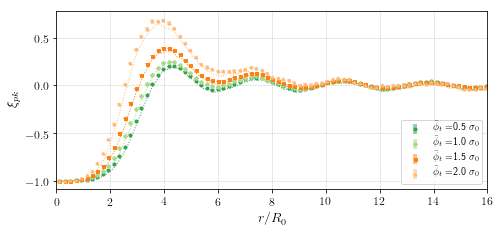

In [81]:
plot_peak_correlators(xrange, filter_size)